# Trees, Forests and the Classification Problem: <br> Simulations & an Application to Redistribution Preferences 

Andreas Koundouros | University of Bonn | Computational Statistics Project | Summer Term 2022

Handed in: August 22, 2022

---

## Table of Contents
* [Preliminaries](#seventh-bullet)
* [1 Introduction](#first-bullet)
* [2 Overview of the Statistical Methods](#second-bullet)
    * [2.1 Classification Trees](#second-one-bullet)
    * [2.2 Random Forests](#second-two-bullet)
* [3 Simulation Studies](#third-bullet)
    * [3.1 The Impact of the Features' Correlation Structure](#third-one-bullet)
    * [3.2 The Issue of (Highly) Categorical Targets](#third-two-bullet)
    * [3.3 The Problem of Omitted Features](#third-three-bullet)
* [4 Economic Application](#fourth-bullet)
    * [4.1 Empirical Results](#fourth-one-bullet)
    * [4.2 Discussion](#fourth-two-bullet)
* [5 Conclusion](#fifth-bullet)
* [References](#sixth-bullet)
* [Appendix](#eighth-bullet)

---

### Preliminaries <a class="anchor" id="seventh-bullet"></a>

This thesis is best viewed in Jupyter Notebook. All required material, e.g. the `R` codes and the data set, can be found in my [GitHub repository](https://github.com/andkound98/Summer22CompStatProject). To run the `R` code included in this notebook, install (if necessary) and load the following `R` packages and source the function file.

In [1]:
# Install (if necessary) and load the following required packages
suppressMessages(library(MASS))             # For multivariate data simulation
suppressMessages(library(dplyr))            # For data wrangling
suppressMessages(library(rpart))            # For tree estimation
suppressMessages(library(rpart.plot))       # For tree plotting
suppressMessages(library(randomForest))     # For random forests 
suppressMessages(library(foreign))          # For importing STATA data files
suppressMessages(library(latex2exp))        # For TeX in plots
suppressMessages(library(tictoc))           # For measuring running time
rm(list=ls())                               # Clean the current environment 
seed <- 123                                 # Seed used throughout for reproducibility 
setwd("./Code_and_Data") # NOTE: Set this working directory as appropriate
source("R_Functions.R") # Source function file

---

## 1 Introduction <a class="anchor" id="first-bullet"></a>

By now, machine learning methods, such as K-nearest neighbours, decision trees and neural networks, have found their way into empirical economic analysis. *Varian (2014)* provides an insightful overview of some of these methods from an economist's perspective. The present project is motivated by these methods' success and discusses two of them in the context of the classification problem. One machine learning solution to this problem are **classification trees**, which provide an interpretable, but often statistically unstable approach. **Random forests** aim at improving the single-tree classifier by aggregating multiple trees, thereby weakening interpretability. 

Shedding light onto the statistical strengths and weaknesses of trees and forests in various settings is the goal of this project’s simulation studies. They show that: 1) multicollinearity is not a significant problem for trees and forests, 2) the performance of these methods is decreasing in the number of categories of the outcome and 3) the problem of omitting relevant features is, as expected, a sizeable issue.

After presenting the simulations, an economic application replicates the approach by *Keely & Tan (2008)*, abbreviated by *KT* hereafter, in a small-scale fashion. The authors apply classification trees and random forests to explore the factors behind individual preferences for government redistribution of incomes. Unlike *KT* find, the present application shows that a respondent's ethnicity is not an important determinant for these preferences. In contrast, age, family income and region of upbringing seem to be relevant. 

The rest of this paper is structured as follows. [Section 2](#second-bullet) succinctly reviews the theory of the methods. [Section 3](#third-bullet) conducts the simulation studies. Subsequently, [section 4](#fourth-bullet) is concerned with the economic application and [section 5](#fifth-bullet) concludes. 

## 2 Overview of the Statistical Methods <a class="anchor" id="second-bullet"></a>

To formalise the classification problem, let $y$ be a categorical target variable, i.e. an outcome with $J \in \mathbb{N}$ distinct categories or classes. Associated to each observation, indexed by $i = 1,..., N$, is a set of $p$ feautures, either discrete or continuous, summarised in the $N \times p$-matrix $X$. Then, the classification problem is the issue of determining to which class $j = 1, ..., J$ observation $i$ belongs, given the realisation of its feautures. The performance of a method in such an exercise is quantified by the share of misclassified test data observations. This next subsections present classification trees and random forests as solutions to this problem.

### 2.1 Classification Trees <a class="anchor" id="second-one-bullet"></a>
Classification (and regression) trees are a non-parametric statistical method popularised mainly by *Breiman et al. (1984)*. As illustrated in the textbooks by *James et al. (2021)* and *Hastie et al. (2009)*, the essential procedure of trees rests on recursive binary splitting, the objective of which is to iteratively find binary, rectangle-shaped partitions of the feature space that minimise the heterogeneity of the composition of observations that fall into the resulting partitions, subject to not overfitting the data (see also *KT*, Technical Appendix).

Formally, the algorithm finds - in its first step - for which feauture $X_d$ and which split value $s$ in the support of $X_d$, the heterogeneity of the observations in the two resulting partitions is minimised. Following *KT*'s explanations, I use $L = \{ X | X_d < s \}$ and $R = \{ X | X_d \ge s \}$ to indicate the subsets that correspond to the left and right path of the tree, respectively. The above process subsequently continues with further partitioning one of the subsets $L$ or $R$ and stops when a certain criterion, e.g. a minimum number of observations in each partition, is reached. The result are $M$ final partitions of the feature space, called leaves. In classification, observation $i$'s prediction follows majority voting, i.e. class $j$ is assigned to $i$ whenever most (training) observations in $m = 1, ..., M$ belong to $j$. 

There are various measures available for quantifying heterogeneity (often called impurity) in a partition of a classification tree (*Hastie et al., 2009, p. 309*). Commonly used is the Gini impurity index. Formally, and in slight deviation of the notation in the textbooks, the objective of the algorithm at the first step is: 

$$\text{min} \ (d,s) \ \ \Bigg\{ \frac{N_L}{N_L+N_R} \sum_{j = 1}^J \hat{p}_{Lj} (1 - \hat{p}_{Lj}) + \frac{N_R}{N_L+N_R} \sum_{j = 1}^J \hat{p}_{Rj} (1 - \hat{p}_{Rj}) \Bigg\},$$

where clearly, $L$ and $R$ are functions of $d$ and $s$ (see above). $\hat{p}_{Lj} = \frac{\sum_{x_i \in L} I(y_i = j)}{N_L}$ is the share of training data falling in $L$ belonging to $j$ (*Hastie et al., 2009, p. 309*). $N_L$ is the number of observations in $L$. Importantly, the above objective is minimised for values of $\hat{p}_{Lj}$ that are either very close to 1, i.e. the node consists almost purely of observations from class $j$, or 0, in which case the node includes almost no observations from $j$. Thus, with the Gini index, pure leaves are preferred (*James et al., 2021, p. 336*). Note that there are alternatives to the Gini index but the `R` implementation `rpart` makes use of it by default (see p. 21 of the package [documentation](https://cran.r-project.org/web/packages/rpart/rpart.pdf)). Of course, in the next steps of the algorithm, the same logic of splitting continues to hold, despite the partitions' representations becoming more involved. 

Fully-grown trees suffer from overfitting. That is, a tree might perfectly classify the training observations but will, in the process, also fit the noise in the data and thus fail to detect the general patterns in the data. To attain a better out-of-sample performance, the tree must be "pruned", i.e. the number of its final partitions must be reduced. Despite introducing bias, this usually leads to a reduction in the predictions' variance in the sense that small changes in the data do not yield vastly different trees and predictions (recall the variance-bias trade-off). 

Pruning is performed by introducing a complexity cost to the above minimisation problem. This cost usually takes the simple form $\alpha |T|$, where $|T|$ is the number of leaves in the final tree and $\alpha$ the weight given to the complexity cost. Consequently, we now penalise the increase in leaves and reduce the optimal tree's size. Evidently, for $\alpha > 0$, a smaller tree will be the solution to the minimisation problem. The optimal $\alpha$ is obtained through $K$-fold cross-validation, where "optimal" means that the resulting tree will yield the lowest average misclassification error out-of-sample (*Varian, 2014, p. 11*). The `rpart()` function automatically determines a pruned tree, unless $\alpha = 0$. 

### 2.2 Random Forests <a class="anchor" id="second-two-bullet"></a>
Random forests, pioneered inter alia by Ho (1995) and Breiman (2001), intend to increase the pre- diction accuracy of single trees by pooling predictions from a (finite) series of trees to arrive at a single prediction for observation i. Random forests thus belong to the ensemble methods.

In detail, random forests are an enhanced version of the bagging procedure, which aims at reducing the variance of trees' predictions (*Hastie et al., 2009, p. 587*). Bagging grows $B$ unpruned trees on $B$ corresponding bootstrapped data sets of size $N$. The predicted class for $i$ is then simply the result of the majority vote of the $B$ trees on $i$ (*James et al., 2021, p. 340-341*).

Random forests proceed similarly but differ in that each tree in step $b = 1, ..., B$ gets to choose only from a random selection of the $p$ feautures at each splitting point (*Hastie et al., 2009, p. 588*), i.e. only a subset $m$ of the $p$ columns of $X$ is available to the algorithm at each point where a split is made. A common choice is $m \approx \sqrt{p}$. But, as already *Breiman (2001)* points out, $m = 1$ might also produce surprisingly good results. As *Hastie et al. (2009)* emphasise, $m$ should be regarded as a tuning parameter and is thus subject to influence by the researcher. 

Through the randomisation of the features, random forests promise to de-correlate the trees and thus their predictions. This is achieved by forcing the algorithm to sometimes ignore important features, which in bagging would appear very often at the top of each tree. The argument then is that the mean (or majority vote) of the now uncorrelated predictions (which are fairly unbiased due to the lack of pruning) should tend to a prediction with significantly lower variance as $B$ gets large (*Hastie et al., 2009, p.587-588*), thus improving the single-tree predictions' stability. 

A downside of random forests is their reduced interpretability as their aggregated classification process cannot be represented by a single tree (*James et al., 2021, p. 343*). However, an advantage is that measures quantifying variable importance can be easily obtained. This is useful in a plethora of settings. *KT* and this project use them to double-check the single-tree results. Multiple variable importance measures are available. The measure used here is obtained by averaging over the sum of the Gini index improvements a certain feature yields for each tree (*James et al., 2021, p.343*).

##  3 Simulation Studies <a class="anchor" id="third-bullet"></a>

Next, this section aims at challening classification trees and random forests with three real-world emulating simulation studies. Specifically, the [first simulation](#third-one-bullet) is concerned with the impact that the correlation structure in $X$ has. The [second simulation](#third-two-bullet) probes into the effects that increases in $J$ have on the prediction accuracy of trees and forests. Finally, [simulation 3](#third-three-bullet) aims at understanding the omitted features problem in the context of these tree-based methods. The last two simulations in particular offer results that are relevant to the economic application. 

Each simulation describes the theoretical setting and some a priori expectations, then presents the implemented code and evaluates the findings. Importantly, the separate `R` file ***R_Functions.R*** includes functions for various data generating processes, for classification tree and random forest estimation (with a default of $B = 200$) as well as their error rates.

### 3.1 The Impact of the Features' Correlation Structure <a class="anchor" id="third-one-bullet"></a>
The first simulation study investigates how changes in the correlation matrix of the features, $\Sigma$, affect the classifications by trees and forests. As is well-known from introductory econometrics, the standard approach of Ordinary Least Squares (OLS) (admittedly, usually not applied in classification problems) becomes less reliable in a multicollinear setting, i.e. when the correlation among the features is very high (see e.g. *Hill et al., 2018, p.288-292*).

How do trees and forests react to changes in $\Sigma$? A priori, one would expect the problem of high correlation in $X$ not to be as severe as in OLS. This is because trees and forests are prediction devices as opposed to tools for inference as OLS usually is (for a discussion on prediction vs inference, see *James et al., 2021, p. 17-20*). Hence, trees and forests try to exploit the features' information only for determining a best guess to classify the outcome. To that end, (high) correlation might even be helpful. As *Hill et al. (2018)* state: "To have a good predicitve model, \[the outcome\] needs to be highly correlated with the variables in \[X\] (...)" (*Hill et al., 2018, p. 283*). The difference between methods for prediction and OLS for inference is also reflected in the differing ways of how the performance of the methods is usually evaluated. With classification trees and forests, the classification error takes centre stage, a metric which might very well not deteriorate in a high-correlation setting. With OLS, standard errors are important and these are heavily affected by $\Sigma$.

We follow a straightforward approach to test these expectations. After defining some parameters (in a mostly ad hoc manner), e.g. $N$, the features' means, etc., the code loops over 100 seeds, for each of which, the following correlation matrix is iterated upon several times: 

$$ \Sigma_t = \begin{bmatrix} 1 & \frac{1}{t^2} & \frac{1}{\sqrt{t}} \\
                            \frac{1}{t^2} & 1 & \frac{1}{\sqrt{t^{\frac{1}{2}}}} \\ 
                            \frac{1}{\sqrt{t}} & \frac{1}{\sqrt{t^{\frac{1}{2}}}} & 1 \end{bmatrix},$$

where $t = 1, 5, ..., 297$ and thus the correlations go to 0 with varying speeds for increasing $t$. Each $\Sigma$ leads to new data, in which the features are **continuous** and multivariately normally distributed, as this makes the simulation of correlated data very easy. The features, together with normally distributed errors $\varepsilon$, are combined non-linearly and with interactions to generate a numeric outcome: $y = X_1(X_2 + X_3 - X_3^2) + \sum_{k = 1}^{3} \beta_k X_k + \varepsilon$, which is made categorical by assigning 0/1 to $y$-values below/above the mean. Then, classification tree and random forest estimation is carried out on a training data set. For the random forest, the test-classification-error minimising m is calculated first and then used. In the end, the share of misclassified test observations is calculated for each $\Sigma$ as a mean over the seeds for each method, respectively. A plot summarises the results. This simulation runs about one hour on an average laptop.

3395.777 sec elapsed


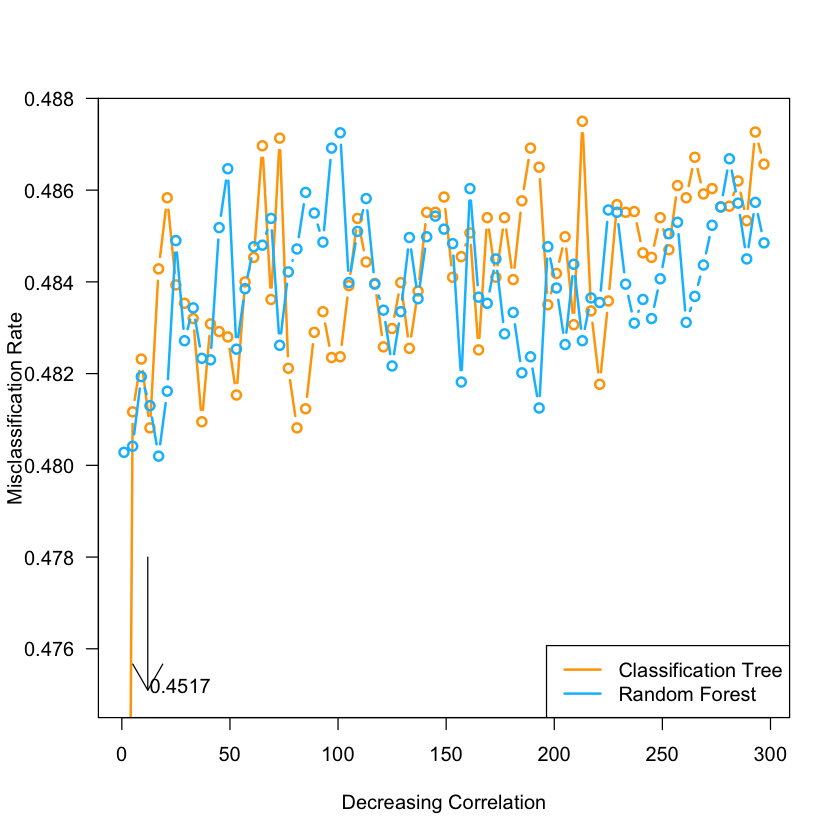

In [2]:
# Simulation Study 1 ###########################################################
tictoc::tic()###################################################################
N <- 1200 # Number of observations
error_mn <- 0 # Mean of the error terms 
error_sd <- 10 # Standard deviation of the error terms
p <- 3 # Number of features 
mu <- c(rep(0, times = p)) # Vector of means of the features
beta <- c(rep(0.5, times = p)) # Some coefficient vector 
reps <- 300 # Last value in loop
reps.vec <- seq(from = 1, to = reps, by = 4) # Sequence for the simulations
noseed <- 100 # Number of seeds
errors.tr <- matrix(data = NA, nrow = noseed, ncol = length(reps.vec)) 
# CT container
errors.rf <- matrix(data = NA, nrow = noseed, ncol = length(reps.vec)) 
# RF container
for (s in 1:noseed) {# Loop over seeds
  for (t in reps.vec) { # Simulation 
    Sigma <- matrix(data = c(1,           1/(t^2),         1/sqrt(t),
                             1/(t^2),     1,               1/sqrt(t^(1/2)), 
                             1/sqrt(t),   1/sqrt(t^(1/2)), 1), # Correlation
                    # matrix as the diagonal is normalised to unity; the rest of 
                    # the terms go to zero with varying speeds
                    ncol = 3, nrow = 3, byrow = TRUE) # Sequence of matrices with 
    # decreasing correlation of features; if p > 3, Sigma needs to be adjusted  
    set.seed(s)
    dt <- data.gen.sim1(obs = N, x.mean = mu, x.cov = Sigma, 
                        error.mean = error_mn, error.sd = error_sd, 
                        coeff = beta) # Obtain data from data generator 
    train.i <- sample(1:nrow(dt), (dim(dt)[1]/2), replace = FALSE) # Split data
    train.data <- dt[train.i,] # Training data
    test.data <- dt[-train.i,] # Test data
    
    res.tr <- tree.fun(form = (y.cat ~ .), dt.train = train.data, # CT 
                       dt.test = test.data, test.Y = test.data$y.cat)
    
    opt.m <- rf.opt.m(p = length(mu), equation = (y.cat ~ .), 
                      dt.tr = train.data, dt.te = test.data, 
                      te.y = test.data$y.cat) # Find optimal RF
    res.rf <- rf.fun(form = (y.cat ~ .), dt.train = train.data, 
                     dt.test = test.data, test.Y = test.data$y.cat, imp = FALSE, 
                     m = opt.m) # Optimal RF 
    
    k <- match(t, reps.vec) # In order to be able to store the results correctly 
    errors.tr[s, k] <- res.tr$misclass.error # Misclassification rate CT
    errors.rf[s, k] <- res.rf$misclass.error # Misclassification rate RF
  }
}
plot(reps.vec, colMeans(errors.tr), type = "b", las = 1, col = "orange", 
     xlab = "Decreasing Correlation", ylab = "Misclassification Rate", lwd = 2,
     ylim = c(0.475, 
              max(colMeans(errors.tr), colMeans(errors.rf)))) # Plot CT's
# misclassification rate depending on the features' correlation
lines(reps.vec, colMeans(errors.rf), type = "b", lwd = 2, col = "deepskyblue")#RF
legend("bottomright", legend = c("Classification Tree", "Random Forest"),
       col = c("orange", "deepskyblue"), lwd = 2, cex = 1) # Legend
text(27, 0.4752, "0.4517") # Mark the outlier 
arrows(x0 = 12, y0 = 0.478, x1 = 12, y1 = 0.4751, code = 2)
tictoc::toc()###################################################################

Evidently, the results show that the misclassification rates of trees and forests are not dramatically affected by multicollinearity, as changes to $\Sigma$ do not lead to significant changes in the classification errors. Indeed, the results hint towards slightly higher out-of-sample prediction accuracy of the two methods for (very) high correlations in $X$. However, this is a quite tentative conclusion and further tests with varying parameters would be required to explore if this result is solely due to randomness.

Nonetheless, the absence of a accuracy deterioration seems sensible when distinguishing between inference and prediction. The former becomes increasingly hard in high-correlation settings since discerning the influence of each single factor becomes more difficult. On the other hand, trees and forests aim at predicting $y$. There, increased correlation does not seem to hurt and might even help at classifying $y$.

### 3.2 The Issue of (Highly) Categorical Targets <a class="anchor" id="third-two-bullet"></a>
Turning to the next simulation, we aim at understanding the impact of increasing the number of categories in the target. That is, how does $J$ affect the prediction accuracy? This is a highly relevant question for the application in [section 4](#fourth-bullet), as the latter revolves around classification of an outcome with $J = 7$.

Theoretically, an increase in the number of categories should, ceteris paribus, lead to an increase in the error rates of trees and forests. This is also stated by *KT*: "(...) misclassification rates tend to increase with greater number of categories for the outcome response variable" (*KT*, p. 949). Naturally, with increasing $J$, the algorithms have more classes to which they can assign observations to. This increased uncertainty makes it harder to identify the patterns governing the data and should thus worsen predictive performance. 

As above, this simulation first fixes some relevant parameters, then generates, for each seed, $y$ in the same way as [section 3.1](#third-one-bullet) does, but with a fixed $\Sigma$. For each data set, another loop increases, step by step, the number of classes in $y$. Class creation is performed in a deterministic way: ever more equidistant splits of the range of $y$ are performed and values inbetween two splits are assigned to a class $j = 1, ..., J$. Subsequently, the methods are fit on training data and evaluated on test data. As the data are randomly generated, it is not ensured that in each seed, each class $j$ in $y$ is non-empty. Thus, the instances where empty classes appear are omitted from the mean over the seeds, thereby ensuring reproducability. Running time here is roughly twelve minutes.

732.72 sec elapsed


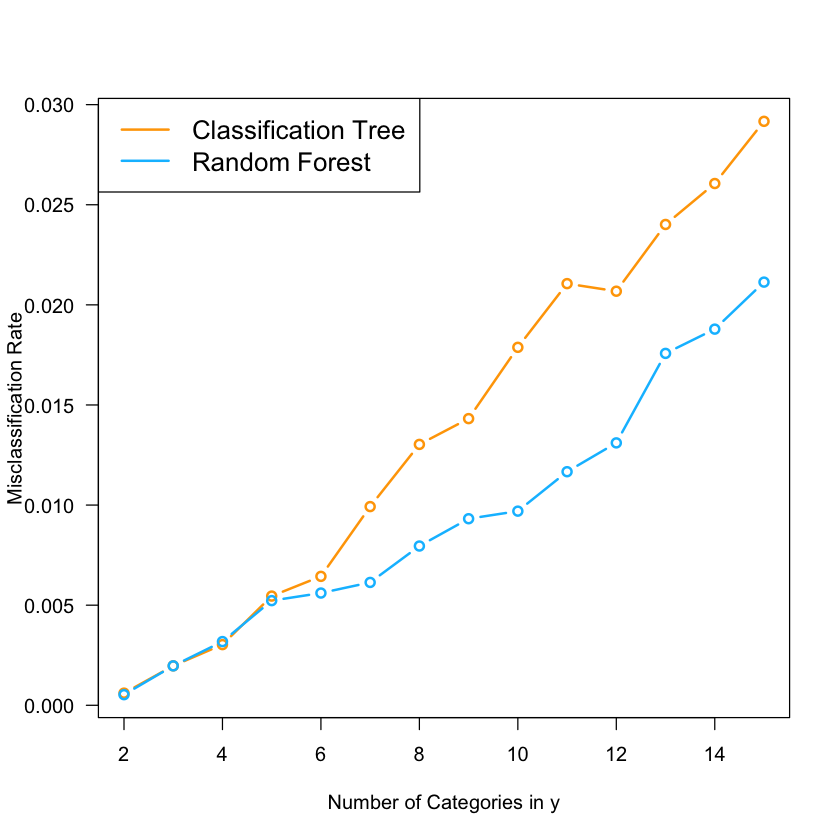

In [3]:
# Simulation Study 2 ###########################################################
tictoc::tic()###################################################################
N <- 1200 # Number of observations
error_mn <- 0 # Mean for normally distributed errors
error_sd <- 10 # Standard deviation for normally distributed errors
p <- 3 # Number of features
mu <- c(rep(0, times = p)) # Vector of means of the features
Sigma <- matrix(data = c(1, 0.3, -0.1, 0.3, 1, 0.9, -0.1, 0.9, 1), nrow = p, 
                ncol = p, byrow = TRUE) 
# Positive definite covariance matrix; if p > 3,Sigma needs to be adjusted 
beta <- c(rep(0.5, times = p)) # Some coefficient vector 
J <- 15 # Maximum number of categories in the outcome
noseed <- 200 # Number of seeds
errors.tr <- matrix(data = NA, nrow = noseed, ncol = (J-1)) # CT container
errors.rf <- matrix(data = NA, nrow = noseed, ncol = (J-1)) # RF container
for (s in 1:noseed) { # Loop over seeds
  set.seed(s)
  data <- data.gen.sim2(obs = N, x.mean = mu, x.cov = Sigma, 
                        error.mean = error_mn, error.sd = error_sd,
                        coeff = beta) # Data with normally distributed errors
  for (t in 2:J) { # Loop over number of categories in the outcome
    dt <- make.cat(dt = data, nocat = t) # Create t categories in the outcome 
    train.i <- sample(1:nrow(dt), (dim(dt)[1]/2), replace = FALSE) # Split data
    train.data <- dt[train.i,] # Training data
    test.data <- dt[-train.i,] # Test data
    
    cnt1 <- train.data %>% count(y.cat, .drop = FALSE) # Count observations per 
    # class in training data 
    cnt2 <- test.data %>% count(y.cat, .drop = FALSE) # Count observations per 
    # class in test data 
    cnt <- rbind(cnt1, cnt2) 
    if(0 %in% cnt[,2] == TRUE){ # If empty classes, skip estimations
      errors.tr[s, t-1] <- NA
      errors.rf[s, t-1] <- NA
    }else{ # If no empty classes, perform estimations
      res.tr <- tree.fun(form = (y.cat ~ .), dt.train = train.data, 
                         dt.test = test.data, test.Y = test.data$y.cat) # CT 
      
      opt.m <- rf.opt.m(p = length(mu), equation = (y.cat ~ .), 
                        dt.tr = train.data, dt.te = test.data, 
                        te.y = test.data$y.cat)
      res.rf <- rf.fun(form = (y.cat ~ .), dt.train = train.data, 
                       dt.test = test.data, test.Y = test.data$y.cat,
                       imp = FALSE, m = opt.m) # Optimal RF 
      
      errors.tr[s, t-1] <- res.tr$misclass.error # Misclassification rate CT
      errors.rf[s, t-1] <- res.rf$misclass.error # Misclassification rate RF 
    }
  }
}
errors.mean <- rbind(colMeans(na.omit(errors.tr)), colMeans(na.omit(errors.rf)))
y.limits <- c(min(errors.mean), max(errors.mean))
plot(2:J, errors.mean[1,], type = "b", las = 1, lwd = 2, col = "orange",
     xlab = "Number of Categories in y", ylab = "Misclassification Rate", 
     ylim = y.limits) # Plot the misclassification rate of CT depending on 
# the number of categories in y
lines(2:J, errors.mean[2,], type = "b", col = "deepskyblue", lwd = 2) # Add RF
legend("topleft", legend = c("Classification Tree", "Random Forest"),
       col = c("orange", "deepskyblue"), lwd = 2, cex = 1.3) # Legend
tictoc::toc()###################################################################

The simulation corroborates the ex ante reasoning. As the plot illustrates, augmenting the number of classes in $y$ lets the algorithms perform worse, ceteris paribus. Thus, all else equal, these tree-based methods lose on predicitve ability when the outcome is categorical of (very) high order. Naturally, the increase in the misclassification rate is more pronounced for the single trees than for the random forests.

A fair criticism to this simulation is that, as the number of categories in $y$ increases, the number of observations per category obviously decreases. One could argue that this is the factor driving the higher misclassification rates for larger $J$'s. From a statistical standpoint, this is definitely a relevant argument which should be investigated in a more involved simulation. However, from an applied perspective, this argument is weakened as seldomly the number of observations in a data set, e.g. a survey, will be enlarged only because it contains a question with many possible categories.

### 3.3 The Problem of Omitted Features <a class="anchor" id="third-three-bullet"></a> 
The third simulation revolves around another well-known issue in econometrics, namely the omitted variable problem, which refers to OLS failing at providing unbiased estimates if relevant covariates are left out of the estimation (see e.g. *Hill et al., 2018, p. 275-277*). Is this a problem for the present tree-based methods, too? If so, how relevant is its extent? Ex ante, one should expect a noticable effect. This is because, as *James et al. (2021)* explain, omitting variables that are important at forecasting $y$ increases the unreducible error every statistical data include. This in turn should prompt the tree and forest error rates to increase when the algorithms are not provided with a relevant $X$. 

The code again fixes some parameters and then initialises a loop over 100 seeds. However, in contrast to the above, the present setting aims at creating a data set resembling the data used in [section 4](#fourth-bullet) to some extent. Some additional summary statistics from that data, used here to guide some parameter decisions, are calculated in [appendix A](#eighth-first-bullet). In particular, two un-ordered discrete variables, $X_1$ and $X_2$, (resembling **SEX** and **RACE** from [section 4](#fourth-bullet)), one integer feature, $X_3$, (akin to **AGE**) and one numerical variable, $X_4$, (resembling **REALINC**) are generated. $X_4$ is generated conditionally on $X_1$ in order to emulate a correlation. A numeric target is calculated by $y = \frac{1}{1000}(X_1(X_2 + X_3^{\frac{5}{2}} - X_4)) + \sum_{k = 1}^{4} \beta_k X_k + \varepsilon$ (features numeric for this calculation), which is made categorical through assigning 0/1 to $y$-values below/above the mean. Subsequently, estimation proceeds once without $X_4$ and once including $X_4$ alongside all other features. This simulation takes roughly one minute to complete.

65.515 sec elapsed


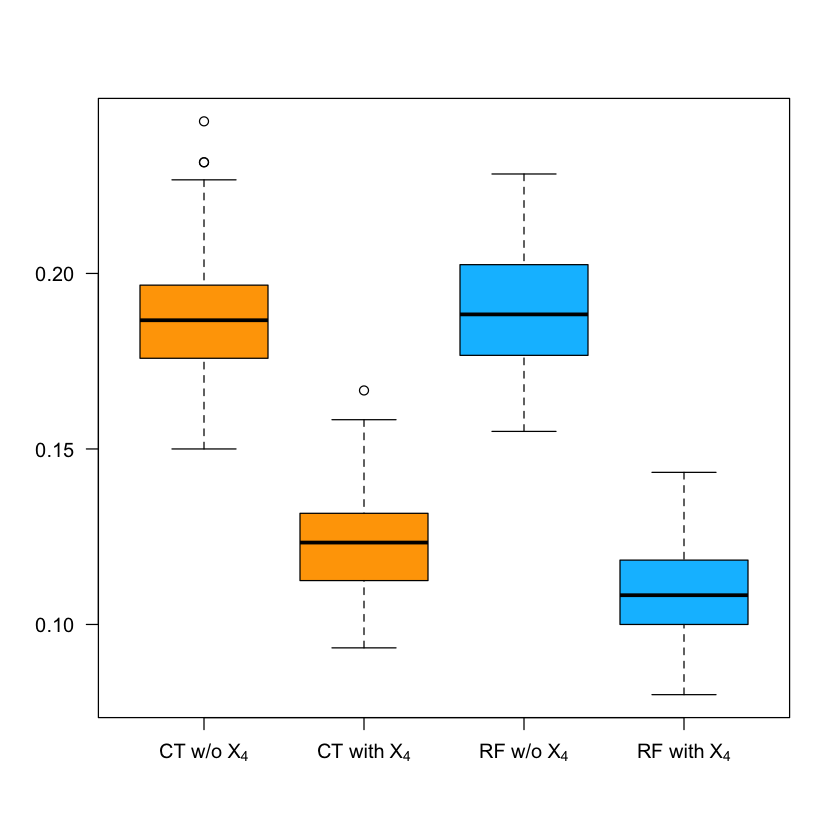

In [4]:
# Simulation Study 3 ###########################################################
tictoc::tic()###################################################################
N <- 1200 # Number of observations
error_mn <- 0 # Mean for normally distributed errors
error_sd <- 10 # Standard deviation for normally distributed errors
beta <- c(rep(0.5, times = 4)) # Some coefficient vector 
noseed <- 100 # Number of seeds
errors.sim3 <- matrix(data = NA, nrow = noseed, ncol = 4, dimnames = 
                   list(c(1:noseed), c("CTnoX_4","CTwX_4","RFnoX_4","RFwX_4")))
# Container for results
for (s in 1:noseed) { # Loop over seeds
  set.seed(s)
  dt <- data.gen.sim3(obs = N, error.mean = error_mn, error.sd = error_sd,
                      coeff = beta)
  train.i <- sample(1:nrow(dt), (dim(dt)[1]/2), replace = FALSE) # Split data
  train.data <- dt[train.i,] # Training data 
  test.data <- dt[-train.i,] # Test data
  
  # Without X[,4]
  res.tr.wo4 <- tree.fun(form = (y.cat ~ . - num), dt.train = train.data, 
                     dt.test = test.data, test.Y = test.data$y.cat) # CT 
  
  opt.m.wo4 <- rf.opt.m(p = (length(beta) - 1), equation = (y.cat ~ . - num), 
                    dt.tr = train.data, dt.te = test.data, 
                    te.y = test.data$y.cat) # Optimal m
  res.rf.wo4 <- rf.fun(form = (y.cat ~ . - num), dt.train = train.data, 
                   dt.test = test.data, test.Y = test.data$y.cat, 
                   imp = FALSE, m = opt.m.wo4) # Optimal RF 
  
  errors.sim3[s, 1] <- res.tr.wo4$misclass.error # Misclassification rate CT
  errors.sim3[s, 3] <- res.rf.wo4$misclass.error # Misclassification rate RF 
  
  # With X[,4]
  res.tr.w4 <- tree.fun(form = (y.cat ~ .), dt.train = train.data, 
                     dt.test = test.data, test.Y = test.data$y.cat) # CT
  
  opt.m.w4 <- rf.opt.m(p = (length(beta)), equation = (y.cat ~ .), 
                        dt.tr = train.data, dt.te = test.data, 
                        te.y = test.data$y.cat) # Optimal m
  res.rf.w4 <- rf.fun(form = (y.cat ~ .), dt.train = train.data, 
                      dt.test = test.data, test.Y = test.data$y.cat, 
                      imp = FALSE, m = opt.m.w4) # Optimal RF
  
  errors.sim3[s, 2] <- res.tr.w4$misclass.error # Misclassification rate CT
  errors.sim3[s, 4] <- res.rf.w4$misclass.error # Misclassification rate RF 
}
boxplot(errors.sim3, las = 1, col = c(rep("orange", 2), rep("deepskyblue", 2)),
        names = c(expression("CT w/o"~X[4]), expression("CT with"~X[4]), 
                  expression("RF w/o"~X[4]), expression("RF with"~X[4])))
tictoc::toc()###################################################################

The boxplot makes clear that omitting the relevant feature $X_4$ from the estimations increases the mis- classification errors significantly. Both, classification tree and random forests, perform better when $X_4$ is included in the estimation. In the latter case, the classification error is in the range of 8-16%, while the range increases to 13-22% when $X_4$ is discarded. This highlights that omitting features that are relevant for the underlying nature of the data is capable of causing statistical handicaps in terms of classification accuracy. Thus, as anticipated, machine learning methods such as the ones examined here do not escape the omitted variable problem and can only be as good as the data they learn from.

## 4 Economic Application: Redistribution Preferences <a class="anchor" id="fourth-bullet"></a>

In order to gain an insight into how the above methods can be applied to an economic setting, we now replicate some of the paper by KT, who research the validity of theories that emphasise identity characteristics in the determination of individual preferences for government income redistribution. KT employ classification trees and random forests on US survey panel data from the General Social Survey (GSS) to classify these preferences using several identity markers.

The present analysis follows *KT* in using GSS data but the more recent 2018 survey is chosen. More information on the data can be found in [appendix A](#eighth-first-bullet). Loading and cleaning the data, including all identity features that *KT* use, leads to a sample with $N = 1,261$ and $p = 10$. Importantly, the classification exercise here concerns the outcome $y =$ **EQWLTH**, which asks the respondent to classify his/her inclination towards income redistribution to a number between 1 (the government should reduce income inequalities through redistribution) and 7 (the government should not concern itself with reducing such inequalities), i.e. $J = 7$.

In [5]:
# Loading and Cleaning the GSS Data ############################################
gss.data.full <- read.dta("./Data/GSS2018.dta")
gss.data <- select(gss.data.full, c("sex", "race", "reg16", "born", "parborn", 
                                    "madeg", "relig16", "fund16", "age",
                                    "realinc", "eqwlth"))
gss.data <- na.omit(gss.data) # Omit NAs
gss.data <- droplevels(gss.data) # Drop unused levels
rownames(gss.data) <- 1:nrow(gss.data) # Re-brand observation numbering
gss.data$eqwlth <- factor(gss.data$eqwlth) # Convert EQWLTH into factor

### 4.1 Empirical Results <a class="anchor" id="fourth-one-bullet"></a>
We now apply classification trees and random forests to the GSS data. Before doing so, note that *KT* proceed a bit differently by using the twoing index to measure node impurity. However, for simplicity and because *KT* state that their results were not very different with the Gini index, the latter is used here.

As in *KT*, we initially fit a classification tree and random forests using all identity markers except for **REALINC**, the respondent's family income. As output, the share of ***correctly*** classified **test** observations of the two methods are reported and the single tree as well as the variable importance measures produced by the random forests are plotted. Note that the random forest is performed with $m=1$, which [appendix B](#eighth-second-bullet) shows to be optimal.

[1] 0.2123613


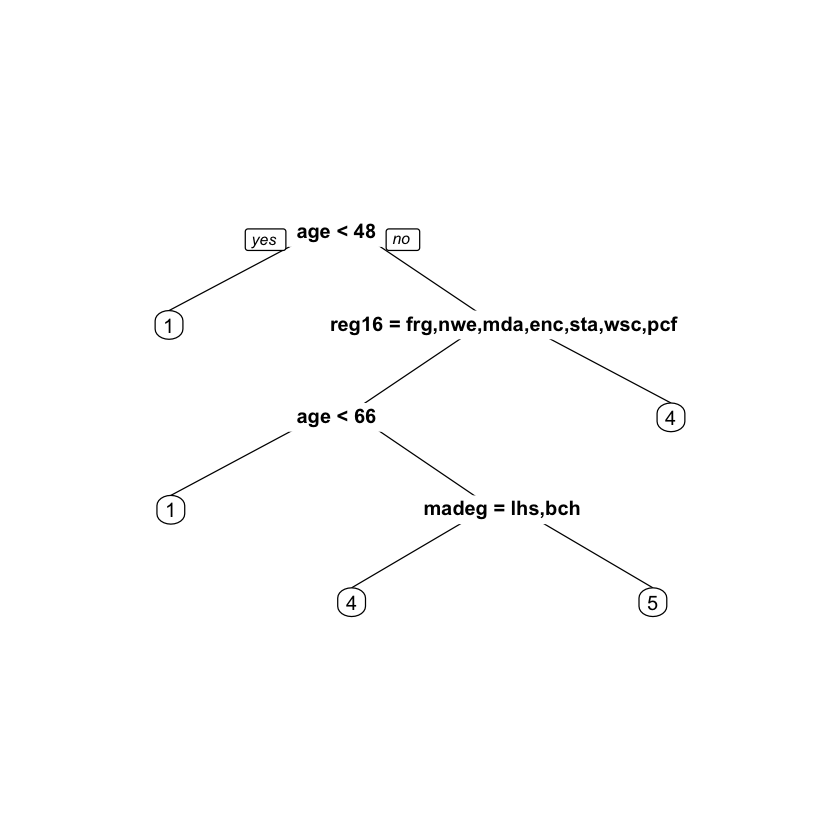

[1] 0.229794


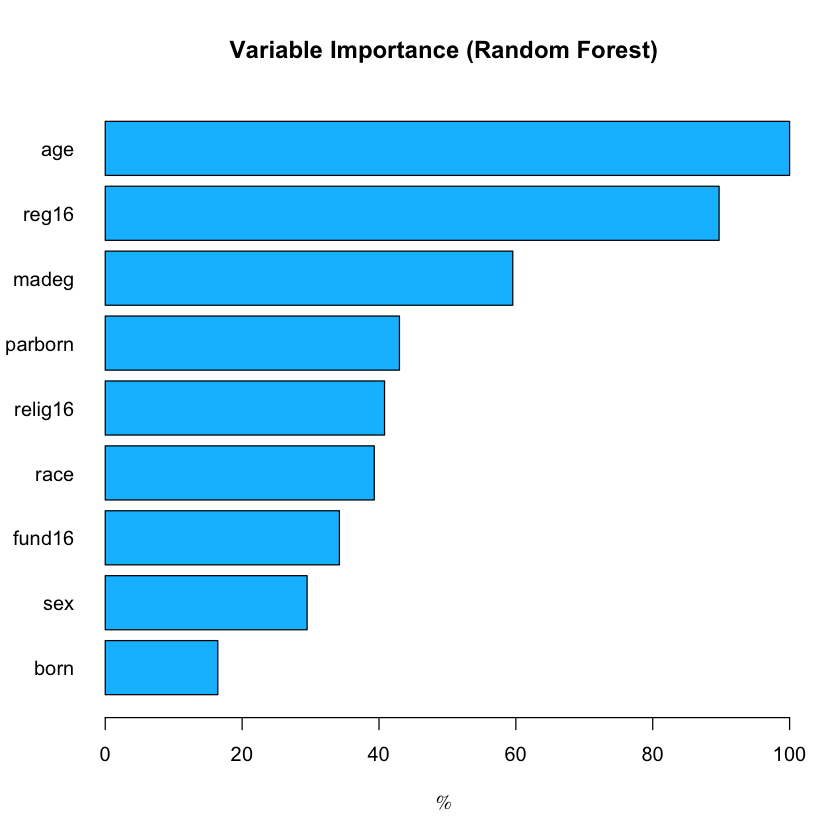

In [6]:
# Splitting the Data into Training and Test Data ###############################
set.seed(seed)
train.i <- sample(1:nrow(gss.data), (dim(gss.data)[1]/2), replace = FALSE)
gss.train.data <- gss.data[train.i,] # Training data 
gss.test.data <- gss.data[-train.i,] # Test data

# Classification Tree (without REALINC) ########################################
tr.gss <- tree.fun(form = (eqwlth ~ . - realinc), dt.train = gss.train.data, 
                   dt.test = gss.test.data, test.Y = gss.test.data$eqwlth, 
                   plot = TRUE)
print(1 - tr.gss$misclass.error) # Share of correct classifications

# Random Forest (without REALINC) ##############################################
set.seed(seed)
rf.gss <- rf.fun(form = (eqwlth ~ . - realinc), dt.train = gss.train.data, 
                 dt.test = gss.test.data, test.Y = gss.test.data$eqwlth, 
                 m = 1, own.vi.plot = TRUE) # m = 1 from appendix B
print(1 - rf.gss$misclass.error) # Share of correct classifications

Perhaps surprisingly, the computed classification tree is starkly different to the corresponding one in *KT* (their table 2). Here, **RACE** is not a splitting feature of the pruned tree, whereas in *KT*, it is the first one. The first split in the present tree partitions the sample into respondents younger than 48 and those older. The young are classified as being strongly in favour of redistribution (1). The older half of the population is further split by the region they used to live in at the age of 16 (**REG16**). In the regions labeled "mountain", "west north central" and "east south central", the support for income redistribution is classified as lower middle (4). The population in the rest of the country is further partitioned into younger than 66 (classified as 1), whereas the ones above that threshold are classified as 4 or 5, depending on the highest educational degree their mother obtained (**MADEG**).

In total, this tree correctly classifies 21.2% of the out-of-sample respondents, which can be believed to be quite bad. Potentially, this result can be understood as evidence for the problem discovered in [section 3.2](#third-two-bullet). As **EQWLTH** has seven categories, the classification poses a more challenging environment for the algorithm  than in a binary-response setting, for example. Considering this, the reported performance is still meaningfully above $\frac{1}{7}$, the best-case performance of random guessing an outcome with $J=7$.

Some of the single-tree results are reflected in the variable importance plot produced by the random forest. **AGE** and **REG16** seem to be the most important predictors, followed by **MADEG**. Unlike in *KT*, **RACE** and **SEX** do not seem to be important classifying features. Also note that the random forest performs slightly better than the single tree with a share of roughly 23% of correct classifications. Interestingly, *KT*'s error rates are quite high, too, at "above 60%" (*KT*, p. 949) for their random forests and higher for their single tree. They also allude to the high number of categories in **EQWLTH** as a reason.

Next, we augment the above by **REALINC**. In the random forest, we again set $m = 1$, see [appendix B](#eighth-second-bullet).

[1] 0.2329635


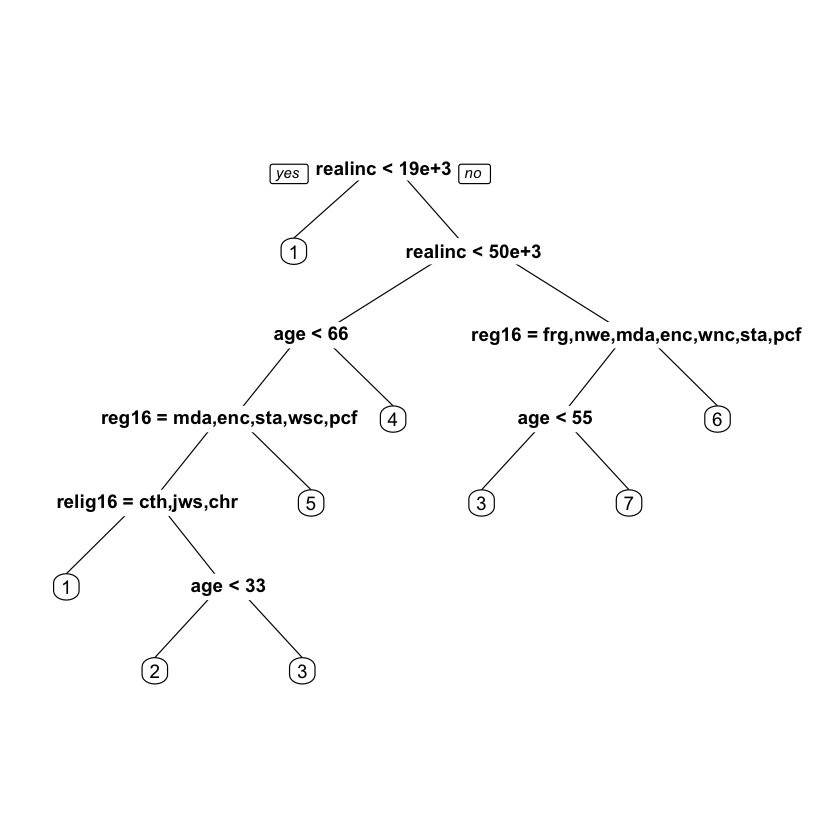

[1] 0.2345483


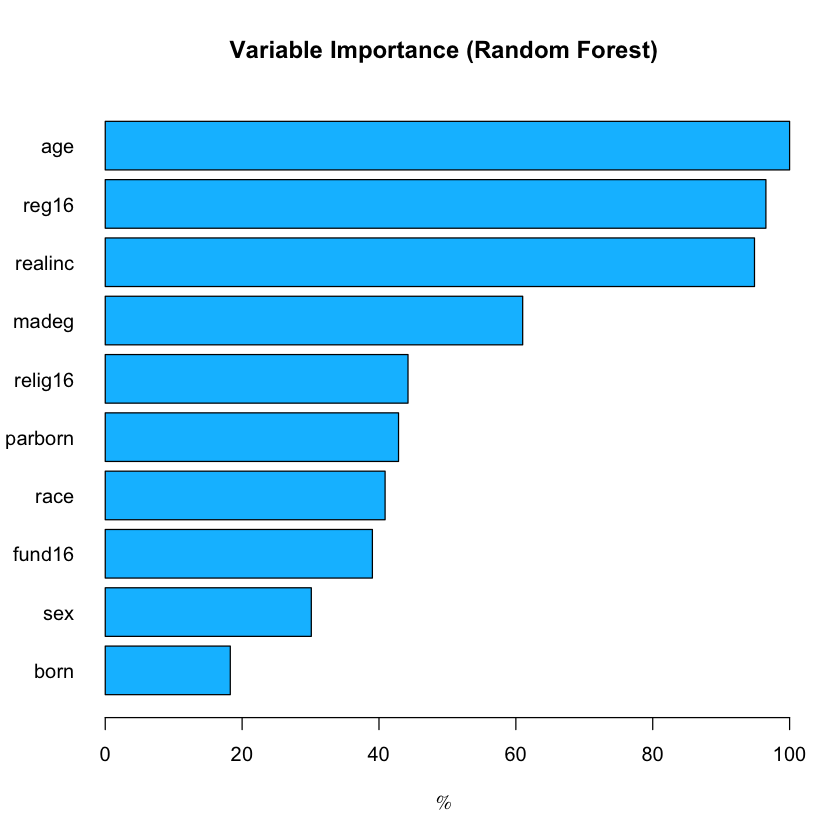

In [7]:
# Classification Tree (with REALINC) ###########################################
tr.gss.rinc <- tree.fun(form = (eqwlth ~ .), dt.train = gss.train.data, 
                        dt.test = gss.test.data, test.Y = gss.test.data$eqwlth, 
                        plot = TRUE)
print(1 - tr.gss.rinc$misclass.error) # Share of correct classifications

# Random Forest (with REALINC) #################################################
set.seed(seed)
rf.gss.rinc <- rf.fun(form = (eqwlth ~ .), dt.train = gss.train.data, 
                      dt.test = gss.test.data, test.Y = gss.test.data$eqwlth, 
                      m = 1, own.vi.plot = TRUE) # m = 1 from appendix B
print(1- rf.gss.rinc$misclass.error) # Share of correct classifications

Startlingly, the new single-tree results are not only very different to those in *KT* (their table 10) but also to the tree without **REALINC**. Now, the first two splits are performed using **REALINC**. Low income respondents are assigned to be very strongly in favour of income redistribution (1), while middle incomes are further partitioned using **AGE**, **REG16** and **RELIG16**, the religion with which the respondent was raised, and are - depending on the exact partition -  classified to be between 1 and 5. The high income group is further split by **REG16** and **AGE** and classification tends more towards being against redistribution, between 3 and 7. Again, in stark contrast to *KT*'s findings, the respondent's ethnicity does not seem to be important in the present data. However, as a similarity to *KT*, **REALINC** seems to be a relevant variable today as it was then, as *KT*'s classification tree includes multiple splits on income, too. Furthermore, classification performance increased somewhat to 23.3%.

Once more, the random forest variable importances corroborate that a respondent’s age, family income and region of upbringing are very important in classifying his redistribution preferences. However, **SEX** and **RACE** seem again to be unimportant for classifying the respondents. Further, note that the random forest once more beats the single tree by a slight margin in terms of predictive performance (23.5%).

### 4.2 Discussion <a class="anchor" id="fourth-two-bullet"></a>
The above results raise a plethora of interesting issues, two of which are touched upon here. First, the question arises why the results here differ so starkly from the ones in *KT* in terms of both essence and (to a lesser degree) performance of the methods. There is a variety of possible reasons, foremost differences in computational implementation of the methods and in sample size (*KT* have a sample of $N > 13,000$). Of course, differences could also arise due to economic and social shifts making ethnicity and sex less related to redistribution preferences.  This conjecture, however, is of quite speculative nature and would have to be investigated in more detail in the future. 

Second and related, it is clear that the present analysis is only a glimpse of what could be done to explain factors driving redistribution preferences. A natural extension to the above would be the use of alternative classifiers, e.g. multinomial logit or boosted trees, or the application of more refined versions of the methods used here. Further, the fact that the respondent's family income seems to be important in the classification process is reminiscent of the omitted feature discussion in [section 3.3](#third-three-bullet) and naturally leads to the question if further relevant features were omitted here. For example, *Olivera (2015)* considers aggregate measures such as inequality and actually implemented redistribution and finds significant effects of both of these within an OLS-like estimation for European panel-data. Thus, the present project should be extended across space and time to include data from other countries and time periods in order to gain a thorough understanding of the formation of redistribution preferences.

## 5 Conclusion <a class="anchor" id="fifth-bullet"></a>

The present project revolved around the classification problem and two solutions to it: classification trees, an agorithm that recursively partitions the feature space by maximising the homogeneity of the partitions, and random forests, a process which aggregates information from many trees. Putting these methods to a real-world-inspired test was the aim of three simulation studies. It turns out that trees and forests are not impacted by multicollinearity as much as one could expect with introductory econometrics knowledge. However, care has to be taken when the target is (highly) categorical. Most likely, only quite large data sets will be able to deliver satisfactory results in that case. Finally, classification accuracy deteriorates dramatically when important features are not available for estimation. 

As an economic application of the methods, this project followed *KT* by using them to analyse US survey data to get a (rough) understanding of how some identity markers shape redistribution preferences. The results here were quite different to those in *KT*. However, as the simulations illustrate, care has to be taken when interpreting the results of these classification exercises. Clearly, the methods applied here are not an exhaustive approach for comprehending how individuals form their preferences for income redistribution. 

---

### References <a class="anchor" id="sixth-bullet"></a>

* Breiman, L. (2001). Random forests. *Machine learning*, 45(1), 5–32. <br> **Free online version**: https://link.springer.com/content/pdf/10.1023/A:1010933404324.pdf
* Breiman, L., Friedman, J.H., Olshen, R.A., & Stone, C.J. (1984). Classification and Regression Trees (1st ed.). New York: Routledge. <br> **Online version**: https://www.taylorfrancis.com/books/mono/10.1201/9781315139470/classification-regression-trees-leo-breiman-jerome-friedman-richard-olshen-charles-stone
* Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning: Data Mining, Inference and Prediction* (2nd ed.). New York: Springer New York. <br> **Free online version**: https://hastie.su.domains/Papers/ESLII.pdf
* Hill, R. C., Griffiths, W. E., & Lim, G. C. (2018). *Principles of Econometrics* (5th ed.). Hoboken, NJ: John Wiley & Sons. <br> **Online version**: https://www.wiley.com/en-us/Principles+of+Econometrics%2C+5th+Edition-p-9781119320944
* Ho, T. K. (1995). Random decision forests. In *Proceedings of 3rd International Conference on Document Analysis and Recognition* (Vol. 1, p. 278-282 vol.1). <br> **Online version**: https://ieeexplore.ieee.org/abstract/document/598994
* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). *An Introduction to Statistical Learning: With Applications in R* (2nd ed.). New York: Springer New York. <br> **Free online version**: https://www.statlearning.com
* Keely, L. C., & Tan, C. M. (2008). Understanding Preferences for Income Redistribution. *Journal of Public Economics*, 92(5-6), p. 944-961. <br> **Online version**: https://www.sciencedirect.com/science/article/abs/pii/S004727270700196X
* Olivera, J. (2015). Preferences for Redistribution in Europe. *IZA Journal of European Labor Studies*, 4(1), 1–18. <br> **Free online version**: https://link.springer.com/content/pdf/10.1186/s40174-015-0037-y.pdf
* Varian, H. R. (2014). Big Data: New Tricks for Econometrics. *Journal of Economic Perspectives*, 28(2), 3-28. <br> **Free online version**: https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.28.2.3 

---

### Appendix <a class="anchor" id="eighth-bullet"></a>

#### Appendix A: Description and Overview of the GSS Data Set <a class="anchor" id="eighth-first-bullet"></a>
This appendix first introduces the survey which provides the data used in the application section ([4](#fourth-bullet)) of this thesis. Thereafter, additional code calculating some summary statistics of the clean data set is presented.


The GSS is a representative, nation-wide, sociological survey of US American adult residents. It is conducted every second year by the National Opinion Research Center at the University of Chicago. In the present work, I exclusively use cross-section data for a single year in order to avoid time series-related issues. 2018 is chosen so as to avoid potential distortions in responses due to the Covid pandemic. The data can be obtained from: https://gss.norc.org/Get-The-Data and an extensive description of how the survey is performed can be found here: https://gss.norc.org/Get-Documentation. 

Note importantly that I select some fewer variables than KT do, in particular only the identity markers. This is because an exact replication of KT's approach would be beyond the scope of this thesis. Second, the only target variable and thus the main variable of interest here is **EQWLTH**. This also deviates slightly from KT's procedure but again simplifies the analysis. Third, the variable **REALINC**, recording the real income of the respondent's family, is used as a feature and as an outcome variable in KT. Here, it will be used exclusively as a feature, which is an intuitive choice. 

**EQWLTH** asks the survey respondent to classify his/her inclination towards income redistribution to a number between 1, standing for: the government should reduce income inequalities through redistribution, and 7, which means: the government should not concern itself with reducing such inequalities. Specifically, the question asked is: 

> Some people think that the government in Washington ought to reduce the income differences between the rich and the poor, perhaps by raising the taxes of wealthy families or by giving income assistance to the poor. Others think that the government should not concern itself with reducing this income difference between the rich and the poor. <br> Here is a card with a scale from 1 to 7. Think of a score of 1 as meaning that the government ought to reduce the income differences between rich and poor, and a score of 7 meaning that the government should not concern itself with reducing income differences. What score between 1 and 7 comes closest to the way you feel?

The variables **SEX**, **RACE**, **AGE** are self-explanatroy. **BORN** and **PARBORN** ask whether the respondent and his parents were born in the US, respectively. **REALINC** is the respondent's (real) family income, **REG16** the region of the US in which the respondent lived at the age of 16 and **MADEG** the highest degree obtained by the mother. The latter is supposed to proxy for socioeconomic background of the respondent. **RELIG16** is the religion in which the respondent was raised and **FUND16** measures how fundamentalist the religious upbringing was. 

With the following code, we obtain an overview of the final data set.

In [8]:
# Overview of the data #########################################################
head(gss.data) # The first 6 observations of the clean data set 
summary(gss.data) # Get summary of the included variables 

,sex,race,reg16,born,parborn,madeg,relig16,fund16,age,realinc,eqwlth
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>
1,female,white,middle atlantic,yes,mother only,lt high school,catholic,moderate,74,14755.0,7
2,male,white,middle atlantic,yes,father only,bachelor,catholic,moderate,42,72640.0,3
3,female,white,middle atlantic,yes,both in u.s,high school,catholic,moderate,63,119879.4,5
4,male,black,middle atlantic,yes,father only,high school,catholic,moderate,71,119879.4,6
5,female,black,middle atlantic,yes,both in u.s,lt high school,protestant,fundamentalist,59,8512.5,5
6,male,white,middle atlantic,yes,both in u.s,high school,catholic,moderate,43,24970.0,1


     sex         race                 reg16      born     
 male  :583   white:930   e. nor. central:227   yes:1127  
 female:678   black:209   south atlantic :207   no : 134  
              other:122   pacific        :165             
                          middle atlantic:160             
                          w. sou. central:133             
                          foreign        :101             
                          (Other)        :268             
             parborn                madeg                   relig16   
 both in u.s     :1021   lt high school:311   protestant        :698  
 mother only     :  44   high school   :637   catholic          :392  
 father only     :  29   junior college: 85   jewish            : 25  
 mother; fa. dk  :   4   bachelor      :161   none              :130  
 not mother;fa.dk:   1   graduate      : 67   orthodox-christian:  9  
 dk for both     :   3                        christian         :  7  
 neither in u.s  : 159         

For an easy comparison of the summary statistics of the present data set with these found in table 1 in *KT*, consider the following code and output.

In [9]:
# Summary Statistics of the Data ###############################################
gss.sumstats <- data.matrix(gss.data[sapply(gss.data, is.factor)])
round(colMeans(gss.sumstats), 2) # Means

sex    race   reg16    born parborn   madeg relig16  fund16  eqwlth 
   1.54    1.36    5.55    1.11    1.86    2.24    1.72    1.94    3.60

In [10]:
round(apply(gss.sumstats, 2, sd), 2) # Standard deviations

sex    race   reg16    born parborn   madeg relig16  fund16  eqwlth 
   0.50    0.65    2.71    0.31    2.01    1.12    1.03    0.74    1.95

Finally, for [section 3.3](#third-three-bullet), we calculate some further statistics in order to make realistic assumptions for the parameters governing the features. 

In [11]:
# Summary Statistics for Section 3.3 ###########################################
table(gss.data$race)[1]/dim(gss.data)[1] # Share of ethnicity "white"
table(gss.data$race)[2]/dim(gss.data)[1] # Share of ethnicity "black"
min(gss.data$age) # Minimum age 
max(gss.data$age) # Maximum age 
mean(gss.data[gss.data$sex == "female", "realinc"]) # Mean family income of women 
mean(gss.data[gss.data$sex == "male", "realinc"]) # Mean family income of men
sd(gss.data[gss.data$sex == "female", "realinc"]) # Standard deviation family 
# income of women
sd(gss.data[gss.data$sex == "male", "realinc"]) # Standard deviation family
# income of men

white 
0.7375099

black 
0.1657415

[1] 18

[1] 89

[1] 32943.18

[1] 37360.41

[1] 31381.96

[1] 32061.36

#### Appendix B: Determining the Optimal $m$ in Random Forests <a class="anchor" id="eighth-second-bullet"></a>
This appendix presents the `for` loops that determined the optimal $m$ in the random forest estimations in [section 4.1](#fourth-one-bullet).

In [12]:
# Find Optimal m in RF (without REALINC) #######################################
p <- 9
res.m <- rep(NA, times = p)
for (q in 1:p) {
  set.seed(seed)
  rf.m <- rf.fun(form = (eqwlth ~ . - realinc), dt.train = gss.train.data, 
                 dt.test = gss.test.data, test.Y = gss.test.data$eqwlth, 
                 m = q)
  res.m[q] <- rf.m$misclass.error
}
min.m <- match(min(res.m), res.m)
print(min.m)

[1] 1


In [13]:
# Find Optimal m in RF (with REALINC) ##########################################
p <- 10
res.m.rinc <- rep(NA, times = p)
for (q in 1:p) { 
  set.seed(seed)
  rf.m.rinc <- rf.fun(form = (eqwlth ~ .), dt.train = gss.train.data, 
                      dt.test = gss.test.data, test.Y = gss.test.data$eqwlth, 
                      m = q)
  res.m.rinc[q] <- rf.m.rinc$misclass.error
}
min.m.rinc <- match(min(res.m.rinc), res.m.rinc)
print(min.m.rinc)

[1] 1


---